<a href="https://colab.research.google.com/github/youngyoung-0/algorithms/blob/main/python_ML_study/seq2seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [139]:
!pip install --upgrade --no-cache-dir gdown

In [140]:
!gdown 1zR1TJm9hjqinSU0OkCcAmaVjfeTgmoOC

Downloading...
From (original): https://drive.google.com/uc?id=1zR1TJm9hjqinSU0OkCcAmaVjfeTgmoOC
From (redirected): https://drive.google.com/uc?id=1zR1TJm9hjqinSU0OkCcAmaVjfeTgmoOC&confirm=t&uuid=3a1bcb23-b08a-4411-aeb3-8a40eb844b38
To: /content/glove.6B.100d.txt
100% 347M/347M [00:06<00:00, 51.2MB/s]


In [141]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from collections import Counter
import urllib.request

In [142]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'use device : {device}')

use device : cuda


In [143]:
BATCH_SIZE = 64
MAX_VOCAB_SIZE = 10000
EMBEDDING_DIM = 100
LATENT_DIM = 512
EPOCHS = 70

In [144]:
url = "https://raw.githubusercontent.com/ironmanciti/infran_NLP/main/data/kor.txt"
file_path = 'kor.text'
urllib.request.urlretrieve(url, file_path)

('kor.text', <http.client.HTTPMessage at 0x78f6815a5a00>)

In [145]:
eng_texts = []
kor_inputs = []
kor_tragets = []

for line in open(file_path, 'r', encoding='utf-8'):
  if '\t' not in line:
    continue
  english, korean, attribution = line.split('\t')

  input_kor = '<sos> ' + korean
  target_kor = korean + ' <eos>'

  eng_texts.append(english)
  kor_inputs.append(input_kor)
  kor_tragets.append(target_kor)

print(f'totla count : {len(eng_texts)}')
print('English : ', eng_texts[1100 : 1110])
print('Korean : ', kor_inputs[1100 : 1110])
print('Korean : ', kor_tragets[1100 : 1110])


totla count : 3318
English :  ["Don't lie anymore, OK?", "Don't you laugh at me.", 'French is fascinating.', 'French is interesting.', 'French is very useful.', 'He looked quite tired.', 'He was about to speak.', 'He was born in Africa.', 'I called Tom for help.', "I didn't come by taxi."]
Korean :  ['<sos> 거짓말 하지 마세요, 알았죠?', '<sos> 날 비웃지마.', '<sos> 프랑스어는 매력적이야.', '<sos> 프랑스어는 흥미로워.', '<sos> 프랑스어는 아주 유용해.', '<sos> 그사람은 좀 지쳐보였어.', '<sos> 그사람이 말하려고 했어.', '<sos> 그는 아프리카에서 태어났다.', '<sos> 나는 톰에게 도움을 요청했다.', '<sos> 택시로 안 왔어.']
Korean :  ['거짓말 하지 마세요, 알았죠? <eos>', '날 비웃지마. <eos>', '프랑스어는 매력적이야. <eos>', '프랑스어는 흥미로워. <eos>', '프랑스어는 아주 유용해. <eos>', '그사람은 좀 지쳐보였어. <eos>', '그사람이 말하려고 했어. <eos>', '그는 아프리카에서 태어났다. <eos>', '나는 톰에게 도움을 요청했다. <eos>', '택시로 안 왔어. <eos>']


In [146]:
class SimpleTokenizer :
  def __init__(self, num_words = None, filters = ''):
    self.num_words = num_words
    self.filters = filters
    self.word_index = {}
    self.index_word = {}

  def fit_on_texts(self, texts):
    word_freq = Counter()
    for text in texts:
      if self.filters:
        for char in self.filters:
          text = text.replace(char, ' ')
      words = text.lower().split()
      word_freq.update(words)

    most_common = word_freq.most_common(self.num_words - 1 if self.num_words else None)

    for idx, (word, _) in enumerate(most_common):
      self.word_index[word] = idx
      self.index_word[idx] = word

  def texts_to_sequences(self, texts):
    sequences = []
    for text in texts:
      if self.filters:
        for char in self.filters:
          text = text.replace(char, '')
      words = text.lower().split()
      seq = [self.word_index.get(word, 0) for word in words ]
      sequences.append(seq)
    return sequences



In [147]:
tokenizer_eng = SimpleTokenizer(num_words = MAX_VOCAB_SIZE)
tokenizer_eng.fit_on_texts(eng_texts)
eng_sequences = tokenizer_eng.texts_to_sequences(eng_texts)

print(f'sample : ')
print(eng_sequences[1500])
print(eng_texts[1500])
print(tokenizer_eng.index_word.get(idx, '<UNK>') for idx in eng_sequences[1500])

sample : 
[1155, 10, 4, 82, 213]
Yesterday was a good day.
<generator object <genexpr> at 0x78f6815dfae0>


In [148]:
word2idx_eng = tokenizer_eng.word_index
num_words_eng = min(MAX_VOCAB_SIZE, len(word2idx_eng) + 1)
max_len_eng = max(len(s) for s in eng_sequences)

print(f'sampel data')
print(f'고유 토큰 수 : {len(word2idx_eng)}')
print(f'사용할 단어 수 : {num_words_eng}')
print(f'최대 시퀀스 길이 : {max_len_eng}')

sampel data
고유 토큰 수 : 3327
사용할 단어 수 : 3328
최대 시퀀스 길이 : 101


In [149]:
tokenizer_kor = SimpleTokenizer(num_words=MAX_VOCAB_SIZE, filters = '')
tokenizer_kor.fit_on_texts(kor_inputs + kor_tragets)
kor_input_sequences = tokenizer_kor.texts_to_sequences(kor_inputs)
kor_target_sequences = tokenizer_kor.texts_to_sequences(kor_tragets)

print(f'sample : ')
print(kor_input_sequences[1500])
print(kor_target_sequences[1500])
print([tokenizer_kor.index_word.get(idx, '<UNK>') for idx in kor_input_sequences[1500]])
print([tokenizer_kor.index_word.get(idx, '<UNK>') for idx in kor_target_sequences[1500]])

sample : 
[0, 1163, 86, 2705]
[1163, 86, 2705, 1]
['<sos>', '어제는', '좋은', '날이었다.']
['어제는', '좋은', '날이었다.', '<eos>']


In [150]:
word2idx_kor  = tokenizer_kor.word_index
num_words_kor = len(word2idx_kor) + 1
max_len_kor = max(len(s) for s in kor_target_sequences)

In [151]:
# 패딩 함수
def pad_sequences(sequences,max_len, padding='pre', value =0):
  padded = []
  for seq in sequences:
    if len(seq) < max_len:
      if padding == 'pre':
        seq = [value] * (max_len - len(seq)) + seq
      else:
        seq = seq + [value] * (max_len - len(seq))
    else:
      seq = seq[:max_len]
    padded.append(seq)
  return np.array(padded)

In [152]:
# 데이터 패딩
encoder_inputs = pad_sequences(eng_sequences, max_len=max_len_eng, padding= 'pre')
decoder_inputs = pad_sequences(kor_input_sequences, max_len=max_len_kor, padding= 'post')
decoder_targets = pad_sequences(kor_target_sequences, max_len=max_len_kor, padding= 'post')

print("padding data")
print(f"Encoder inputs: {encoder_inputs.shape}")
print(f"Decoder inputs: {decoder_inputs.shape}")
print(f"Decoder targets: {decoder_targets.shape}")
print(f"\n예시 [1500]:")
print(f"Encoder: {encoder_inputs[1500]}")
print(f"Decoder input: {decoder_inputs[1500]}")
print(f"Decoder target: {decoder_targets[1500]}")

padding data
Encoder inputs: (3318, 101)
Decoder inputs: (3318, 90)
Decoder targets: (3318, 90)

예시 [1500]:
Encoder: [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0 1155   10
    4   82  213]
Decoder input: [   0 1163   86 2705    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0

In [153]:
# GloVe 임베딩로드 함수
def load_glove_embeddings(embedding_dim, tokenizer, max_vocab_size):
  embeddings_dict = {}
  glove_file = './glove.6B.100d.txt'

  try:
    with open(glove_file, encoding='utf-8') as f:
      for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_dict[word] = coefs
    print(f"GloVe 임베딩 로드 완료: {len(embeddings_dict)} words")
  except FileNotFoundError:
    print("GloVe 파일이 없습니다. 랜덤 초기화를 사용합니다.")
    return None

  num_words = min(max_vocab_size, len(tokenizer.word_index) + 1)
  embedding_matrix = np.zeros((num_words, embedding_dim))
  for word, i in tokenizer.word_index.items():
    if i < max_vocab_size:
      embedding_vector = embeddings_dict.get(word)
      if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

  return embedding_matrix


In [154]:
embedding_matrix = load_glove_embeddings(EMBEDDING_DIM, tokenizer_eng, MAX_VOCAB_SIZE)

GloVe 임베딩 로드 완료: 400000 words


In [155]:
# PyTorch Dataset
class TranslationDataset(Dataset):
  def __init__(self, encoder_inputs, decoder_inputs, decoder_targets):
    self.encoder_inputs = encoder_inputs
    self.decoder_inputs = decoder_inputs
    self.decoder_targets = decoder_targets

  def __len__(self):
    return len(self.encoder_inputs)

  def __getitem__(self, idx):
    encoder_input = self.encoder_inputs[idx]
    decoder_input = self.decoder_inputs[idx]
    decoder_target = self.decoder_targets[idx]
    return encoder_input, decoder_input, decoder_target

In [156]:
# Dataset & DataLoader
dataset = TranslationDataset(encoder_inputs, decoder_inputs, decoder_targets)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"\nDataset split:")
print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}")


Dataset split:
Train: 2654, Val: 664


In [157]:
# Encoder 모델
class Encoder(nn.Module):
  def __init__(self, vocab_size, embedding_dim,hidden_dim, embedding_matrix=None):
    super(Encoder, self).__init__()

    self.embedding = nn.Embedding(vocab_size, embedding_dim)

    # GloVe 임베딩이있으면 초기화
    if embedding_matrix is not None:
      self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))

    self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first = True)

  def forward(self, x):
    embedded = self.embedding(x)
    outputs, (hidden, cell) = self.lstm(embedded)
    return hidden, cell


In [158]:
# Decoder 모델
class Decoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(Decoder, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden, cell):
        # x: (batch, seq_len)
        # hidden, cell: (1, batch, hidden_dim)
        embedded = self.embedding(x)  # (batch, seq_len, embedding_dim)
        outputs, (h, c) = self.lstm(embedded, (hidden, cell))
        # outputs: (batch, seq_len, hidden_dim)
        predictions = self.fc(outputs)  # (batch, seq_len, vocab_size)
        return predictions, h, c


In [159]:
# Seq2Seq 모델
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, trg):
        # src: (batch, src_len)
        # trg: (batch, trg_len)

        # Encoder
        h, c = self.encoder(src)

        # Decoder (teacher forcing)
        outputs, _, _ = self.decoder(trg, h, c)

        return outputs

In [160]:
# 모델 초기화
encoder = Encoder(num_words_eng, EMBEDDING_DIM, LATENT_DIM, embedding_matrix).to(device)
decoder = Decoder(num_words_kor, EMBEDDING_DIM, LATENT_DIM)
model = Seq2Seq(encoder, decoder).to(device)

print("\n모델 구조:")
print(model)
print(f"\n총 파라미터 수: {sum(p.numel() for p in model.parameters()):,}")



모델 구조:
Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(3328, 100)
    (lstm): LSTM(100, 512, batch_first=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(5325, 100, padding_idx=0)
    (lstm): LSTM(100, 512, batch_first=True)
    (fc): Linear(in_features=512, out_features=5325, bias=True)
  )
)

총 파라미터 수: 6,111,969


In [161]:
# Loss & Optimizer
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters(), lr= 0.001)

In [162]:
# 학습 함수
def train_epoch (model, loader, criterion, optimizer, device):
  model.train()
  total_loss = 0
  correct = 0
  total = 0

  for enc_input, dex_input, dec_target in loader:
    enc_input = enc_input.to(device)
    dex_input = dex_input.to(device)
    dec_target = dec_target.to(device)

    optimizer.zero_grad()

    # Forward
    outputs = model(enc_input, dex_input)

    # Reshape for loss
    outputs = outputs.view(-1, num_words_kor)
    dec_target = dec_target.view(-1)

    # Loss
    loss = criterion(outputs, dec_target)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    # Accuracy
    pred = outputs.argmax(dim=1)
    mask = dec_target != 0
    correct += ((pred == dec_target) & mask).sum().item()
    total += mask.sum().item()
  return total_loss / len(loader), correct / total

In [163]:
# 평가 함수
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for enc_input, dec_input, dec_target in loader:
            enc_input = enc_input.to(device)
            dec_input = dec_input.to(device)
            dec_target = dec_target.to(device)

            outputs = model(enc_input, dec_input)

            outputs = outputs.view(-1, num_words_kor)
            dec_target = dec_target.view(-1)

            loss = criterion(outputs, dec_target)
            total_loss += loss.item()

            pred = outputs.argmax(dim=1)
            mask = dec_target != 0
            correct += ((pred == dec_target) & mask).sum().item()
            total += mask.sum().item()

    return total_loss / len(loader), correct / total


In [164]:
# 학습 실행
print("\n학습 시작...")
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(EPOCHS):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}/{EPOCHS}')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}\n')


학습 시작...
Epoch 10/70
Train Loss: 3.7740, Train Acc: 0.3268
Val Loss: 6.7835, Val Acc: 0.2540

Epoch 20/70
Train Loss: 1.5164, Train Acc: 0.7107
Val Loss: 7.1584, Val Acc: 0.2838

Epoch 30/70
Train Loss: 0.9035, Train Acc: 0.7975
Val Loss: 7.3574, Val Acc: 0.3055

Epoch 40/70
Train Loss: 0.4335, Train Acc: 0.9213
Val Loss: 7.5426, Val Acc: 0.3166

Epoch 50/70
Train Loss: 0.1544, Train Acc: 0.9767
Val Loss: 7.7883, Val Acc: 0.3145

Epoch 60/70
Train Loss: 0.0736, Train Acc: 0.9834
Val Loss: 8.0017, Val Acc: 0.3142

Epoch 70/70
Train Loss: 0.0517, Train Acc: 0.9842
Val Loss: 8.0929, Val Acc: 0.3195



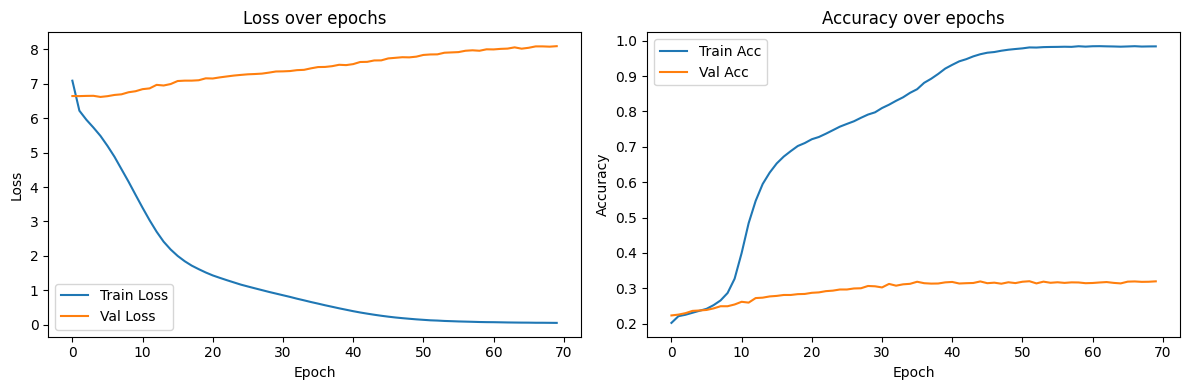

In [165]:
# 학습 결과 시각화
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Val Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.set_title('Loss over epochs')

ax2.plot(train_accs, label='Train Acc')
ax2.plot(val_accs, label='Val Acc')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.set_title('Accuracy over epochs')

plt.tight_layout()
plt.show()

In [166]:
# 모델 저장
torch.save({
    'encoder_state_dict': encoder.state_dict(),
    'decoder_state_dict': decoder.state_dict(),
}, 'seq2seq_translation_pytorch.pt')
print("모델 저장 완료!")

모델 저장 완료!


In [167]:
# 추론 함수
def decode_sequence(encoder, decoder, input_seq, word2idx_kor, idx2word_kor, max_len_kor, device):
    encoder.eval()
    decoder.eval()

    with torch.no_grad():
        # Encoder
        input_tensor = torch.LongTensor(input_seq).to(device)
        h, c = encoder(input_tensor)

        # Decoder 시작
        sos_idx = word2idx_kor.get('<sos>', 1)
        eos_idx = word2idx_kor.get('<eos>', 2)

        decoder_input = torch.LongTensor([[sos_idx]]).to(device)

        output_sentence = []
        for _ in range(max_len_kor):
            predictions, h, c = decoder(decoder_input, h, c)
            # predictions: (1, 1, vocab_size)

            idx = predictions.argmax(dim=-1).item()

            if idx == eos_idx or idx == 0:
                break

            if idx > 0:
                word = idx2word_kor.get(idx, '<UNK>')
                output_sentence.append(word)

            decoder_input = torch.LongTensor([[idx]]).to(device)

        return ' '.join(output_sentence)

In [168]:
# index2word 매핑 생성
idx2word_kor = tokenizer_kor.index_word

In [169]:
# 번역 테스트
print("\n랜덤 샘플 번역 테스트:")
for _ in range(5):
    i = np.random.choice(len(eng_texts))
    input_seq = encoder_inputs[i:i+1]

    translation = decode_sequence(encoder, decoder, input_seq,
                                 word2idx_kor, idx2word_kor,
                                 max_len_kor, device)
    print('-' * 50)
    print(f'Input: {eng_texts[i]}')
    print(f'Translation: {translation}')



랜덤 샘플 번역 테스트:
--------------------------------------------------
Input: We never should've gone to Australia.
Translation: 우린 오직 프랑스어로만 이야기 해.
--------------------------------------------------
Input: Tom is a pretty good poet.
Translation: 톰은 좀 괜찮은 시인이야.
--------------------------------------------------
Input: I think that what you're doing is wrong.
Translation: 네가 하고 있는 것은 틀린 것 같아.
--------------------------------------------------
Input: What color do you like?
Translation: 무슨 색이 좋아?
--------------------------------------------------
Input: If there's any problem, you can reach me on my cellphone.
Translation: 내 (여행용) 가방 어디에 두었니? 톰이 내가


In [174]:
# 영한 번역 함수
def eng_kor_translation(text, encoder, decoder, tokenizer_eng, word2idx_kor,
                       idx2word_kor, max_len_eng, max_len_kor, device):
    # 텍스트를 시퀀스로 변환
    input_sequence = tokenizer_eng.texts_to_sequences([text])
    encoder_input = pad_sequences(input_sequence, max_len=max_len_eng, padding='pre')

    return decode_sequence(encoder, decoder, encoder_input,
                          word2idx_kor, idx2word_kor, max_len_kor, device)

In [175]:
# 커스텀 문장 테스트
test_texts = [
    "Your lips are red.",
    "French is interesting.",
    "I like you.",
    "Let's go to home."
]

print("\n커스텀 문장 번역 테스트:")
for text in test_texts:
    translation = eng_kor_translation(text, encoder, decoder, tokenizer_eng,
                                     word2idx_kor, idx2word_kor,
                                     max_len_eng, max_len_kor, device)
    print('-' * 50)
    print(f'Input: {text}')
    print(f'Translation: {translation}')


커스텀 문장 번역 테스트:
--------------------------------------------------
Input: Your lips are red.
Translation: 네 손이 떨리고 있어.
--------------------------------------------------
Input: French is interesting.
Translation: 프랑스어는 흥미로워.
--------------------------------------------------
Input: I like you.
Translation: 나 약혼했어.
--------------------------------------------------
Input: Let's go to home.
Translation: 난 거기 있을 거야.
